# MCMC with Multiple Likelihoods

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from py21cmmc.mcmc import analyse
from py21cmmc import mcmc

%load_ext autoreload
%autoreload 2

In this tutorial we demonstrate two main ideas: how to use the non-power-spectrum likelihoods provided in ``21CMMC``, and how to use more than one likelihood at a time. The extra likelihoods that we use were called "priors" in previous versions and publications, and they can help break parameter degeneracies in some cases.

In [2]:
import py21cmmc
py21cmmc.__version__

'0.1.0'

## Setting up cores and likelihoods

The various extra likelihoods provided work *best* (but not exclusively) with a Lightcone core, so we will use them in conjunction with a lightcone likelihood. This is because they typically measure the global average of a quantity (either brightness temperature or neutral fraction) as a function of redshift. 

For the core, we take the same as that used in the lightcone MCMC intro:

In [3]:
core = mcmc.CoreLightConeModule( # All core modules are prefixed by Core* and end with *Module
    redshift = 5.5,              # Lower redshift of the lightcone
    max_redshift = 8.0,          # Approximate maximum redshift of the lightcone (will be exceeded).
    user_params = dict(       
        HII_DIM = 50,         
        BOX_LEN = 125.0
    ),
    z_step_factor=1.04,          # How large the steps between evaluated redshifts are (log).
    regenerate=False,
    nchunks=4
) # For other available options, see the docstring.

Now we instantiate several different likelihoods, beginning with the basic 1D power spectrum:

In [4]:
# Now the likelihood...
datafiles = ["data/lightcone_mcmc_data_%s.npz"%i for i in range(4)]
likelihood_ps = mcmc.Likelihood1DPowerLightcone(  # All likelihood modules are prefixed by Likelihood*
    datafile = datafiles,        # All likelihoods have this, which specifies where to write/read data
    logk=False,                 # Should the power spectrum bins be log-spaced?
    min_k=0.1,                  # Minimum k to use for likelihood
    max_k=1.0,                  # Maximum ""
    nchunks = 4,                 # Number of chunks to break the lightcone into
    simulate=True
) # For other available options, see the docstring

likelihood_planck = mcmc.LikelihoodPlanck()  # there are no options here, though some class variables
                                             # can be set to change the behaviour (eg. tau_mean, tu_sigma)
    
likelihood_mcgreer = mcmc.LikelihoodNeutralFraction()  # Again, no required options, though the options
                                                       # redshift, xHI_mean, xHI_sigma can be set. By default
                                                       # they evaluate to the McGreer values.
        
likelihood_greig = mcmc.LikelihoodGreig()

## Running MCMC

In [ ]:
model_name = "MultiLikelihoodTest"

chain = mcmc.run_mcmc(
    core, [likelihood_ps, likelihood_mcgreer, likelihood_greig],#, likelihood_planck],
    datadir='data',          # Directory for all outputs
    model_name=model_name,   # Filename of main chain output
    params=dict(             # Parameter dict as described above.
        HII_EFF_FACTOR = [30.0, 10.0, 50.0, 3.0],
        ION_Tvir_MIN = [4.7, 4, 6, 0.1],
    ), 
    walkersRatio=4,         # The number of walkers will be walkersRatio*nparams
    burninIterations=0,      # Number of iterations to save as burnin. Recommended to leave as zero.
    sampleIterations=100,    # Number of iterations to sample, per walker.
    threadCount=4,           # Number of processes to use in MCMC (best as a factor of walkersRatio)
    continue_sampling=False  # Whether to contine sampling from previous run *up to* sampleIterations.
)

2019-03-27 11:13:34,257 | WARNING | likelihood.py::_write_data() | File data/lightcone_mcmc_data_0.npz already exists. Moving previous version to data/lightcone_mcmc_data_0.npz.bk
2019-03-27 11:13:34,260 | WARNING | likelihood.py::_write_data() | File data/lightcone_mcmc_data_1.npz already exists. Moving previous version to data/lightcone_mcmc_data_1.npz.bk
2019-03-27 11:13:34,263 | WARNING | likelihood.py::_write_data() | File data/lightcone_mcmc_data_2.npz already exists. Moving previous version to data/lightcone_mcmc_data_2.npz.bk
2019-03-27 11:13:34,265 | WARNING | likelihood.py::_write_data() | File data/lightcone_mcmc_data_3.npz already exists. Moving previous version to data/lightcone_mcmc_data_3.npz.bk


## Analysis

### Accessing chain data

Access the samples object within the chain (see the intro for more details):

In [6]:
samples = chain.samples

NameError: name 'chain' is not defined

### Trace Plot

Often, for diagnostic purposes, the most useful plot to start with is the trace plot. This enables quick diagnosis of burnin time and walkers that haven't converged. The function in ``py21cmmc`` by default plots the log probability along with the various parameters that were fit. It also supports setting a starting iteration, and a thinning amount. 

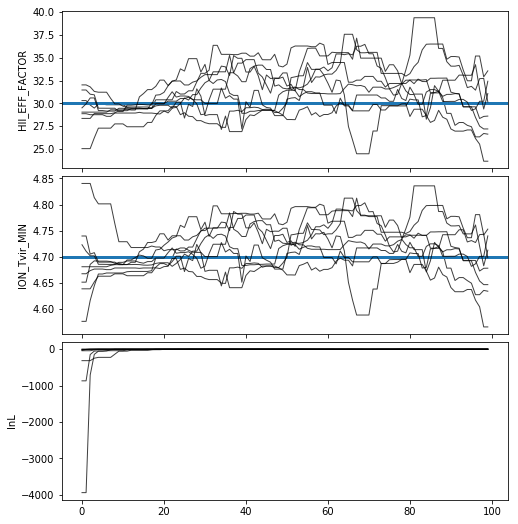

In [7]:
analyse.trace_plot(samples, include_lnl=True, start_iter=0, thin=1, colored=False, show_guess=True);

### Corner Plot

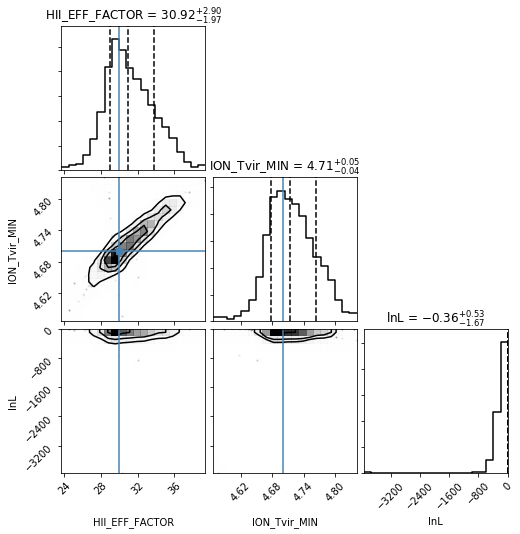

In [8]:
analyse.corner_plot(samples);

## Using the Luminosity Function Likelihood

Another ``Likelihood`` which can be important in breaking degeneracies is the ``LikelihoodLuminosityFunction``. Let's create the structure for this:

In [ ]:
core_lf = mcmc.CoreLuminosityFunction(
    redshifts = [4, 5, 6],    # Generate luminosity functions at z=4,5,6
    user_params = core.user_params,  
)

likelihood_lf = mcmc.LikelihoodLuminosityFunction(
        simulate=True
)